## EGNN ClofNet Training Pipeline

###  Drive Mount & Installation

We mount Google Drive to access the data and install the required **PyTorch Geometric** libraries for our ClofNet GNN implementation.

In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')


!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.0+cu121.html
!pip install torch-geometric

Mounted at /content/gdrive
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 143.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 120.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00


In [2]:
import torch
import sys
import types
import os
import importlib
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import plotly.graph_objects as go

from torch import nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


###  Configuration & Hyperparameters

This cell generates the `config.py` file, which centralizes all experiment parameters. This allows for quick adjustments to the configuration without modifying the model or training code directly.

Key definitions include:
* **Data Paths:** Absolute paths to the dataset (mounted via Google Drive).
* **GNN Architecture:** Hidden channel dimensions (`HIDDEN_CHANNELS`), depth (`DEPTH`)...
* **Optimization:** Batch size, learning rate, and number of epochs.
* **Hardware:** Automatic selection of GPU (CUDA) if available.

In [3]:
# CONFIGURATION Parameters
class Config:

    TRAIN_DATA_PATH = '/content/gdrive/MyDrive/ml_lab_project/Data_lab/train_data.pt'
    VAL_DATA_PATH = '/content/gdrive/MyDrive/ml_lab_project/Data_lab/val_data.pt'

    # Data Parameters
    TRAIN_SUBSET_RATIO = 1.0   # 100% of dataset
    BATCH_SIZE = 64            # Number of graphs processed in parallel

    # Model Architecture (ClofNet)
    IN_NODE_FEATURES = 9       # Input features from dataset
    HIDDEN_CHANNELS = 64       # Hidden dimension size
    OUT_STRESS_DIM = 1         # Scalar output (Von Mises stress)
    DEPTH = 4                  # Number of ClofNet layers

    # ClofNet Specifics
    NORM_DIFF = True           # Normalize difference vectors
    TANH = False               # No limit on virtual movement
    COORDS_WEIGHT = 1.0        # Let the network move the nodes

    # Training Hyperparameters
    NUM_EPOCHS = 50             # Total training iterations
    LEARNING_RATE = 0.001      # Step size for the optimizer
    WEIGHT_DECAY = 1e-12       # L2 Regularization to prevent overfitting
    GRADIENT_CLIP = 1.0        # Max norm for gradients (stabilizes training)

    # --- Saving ---
    BEST_MODEL_PATH = 'best_model.pt'
    TRAINING_CURVE_PATH = 'training_curve_clofnet.png'

    # --- Hardware ---
    # Automatically select GPU if available for faster computation
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()


###  Data Loading Compatibility

Although the dataset is already normalized, the saved `.pt` files contain instances of `UnitGaussianNormalizer`. We explicitly define this class here to ensure `torch.load` can deserialize the data correctly without raising `AttributeError` or warnings.

In [4]:

# This class is necessary to load objects saved with 'utils' in the checkpoint
class UnitGaussianNormalizer:
    def __init__(self, x=None, eps=1e-5):
        self.eps = eps
        self.mean = x.mean(dim=0, keepdim=True) if x is not None else None
        self.std = x.std(dim=0, keepdim=True) + eps if x is not None else None
    def encode(self, x): return (x - self.mean) / self.std if self.mean is not None else x
    def decode(self, x, sample_idx=None): return x * self.std + self.mean if self.mean is not None else x

#sys.modules['utils'] = types.ModuleType('utils')
#sys.modules['utils'].UnitGaussianNormalizer = UnitGaussianNormalizer


### ClofNet Architecture Definition

This cell implements the **ClofNet (Complete Local Frames Network)** architecture from the github (https://github.com/mouthful/ClofNet), adapted here for static stress prediction.  
ClofNet explicitly models 3D geometry by constructing a unique, rotation-equivariant coordinate system (local frame) for every edge.

Key components include:

1.  **Scatter Helpers:** `unsorted_segment_sum` and `unsorted_segment_mean` provide efficient, vectorized aggregation of messages from neighbors, which is essential for the message-passing paradigm.
2.  **`Clof_GCL` (Graph Convolutional Layer):** The core building block.
    * **`coord2localframe`:** Constructs an orthonormal basis for each edge using cross-products of node positions.
    * **`scalarization`:** Projects absolute node coordinates onto these local frames to generate **9 rotation-invariant geometric features** (radial distance + 8 projections/angles). This allows the network to "see" anisotropy without breaking physical symmetries.
    * **`coord_model`:** Updates node positions by predicting scalar coefficients $(\alpha, \beta, \gamma)$ that weight the movement along the local frame axes, ensuring SE(3) equivariance.
3.  **`ClofNetModel` (Wrapper):**
    * Embeds the initial physical features (dimension 9) into a hidden latent space (dimension 64).
    * Stacks multiple `Clof_GCL` layers (defined by `config.DEPTH`).
    * **Safety Mechanism:** In the `forward` pass, we explicitly use `pos = pos.clone()` to ensure the coordinate updates operate on a temporary copy, preventing the corruption of the original dataset geometry in memory.

In [5]:
#--- Helper functions for scatter operations ---
# These functions implement the "Message Aggregation" step of Graph Neural Networks.
# They take messages from edges and sum/mean them into the target nodes.

def unsorted_segment_mean(data, segment_ids, num_segments):
    """
    Computes the mean of 'data' for each segment (node) specified by 'segment_ids'.
    Used to average coordinate updates or features from neighbors.
    """
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def unsorted_segment_sum(data, segment_ids, num_segments):
    """
    Computes the sum of 'data' for each segment (node).
    Standard aggregation for message passing (e.g., summing edge features into nodes).
    """
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    return result

# --- Core ClofNet Layer ---
class Clof_GCL(nn.Module):
    """
    ClofNet Graph Convolutional Layer.

    This layer implements SE(3) equivariance by constructing a 'Complete Local Frame'
    for every edge. Instead of learning on absolute coordinates (which change with rotation),
    it projects geometry onto these local frames to learn invariant features.
    """
    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0,
                 act_fn=nn.SiLU(), recurrent=True, coords_weight=1.0,
                 norm_diff=True, tanh=False):
        super(Clof_GCL, self).__init__()
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.norm_diff = norm_diff
        self.tanh = tanh

        # MLP to process edge features + geometric invariants
        input_edge = input_nf * 2
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn
        )

        # MLP to update node features
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf)
        )

        # MLP to predict scalar coefficients for coordinate updates
        layer = nn.Linear(hidden_nf, 3, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            layer
        )
        if self.tanh:
            self.coord_mlp.append(nn.Tanh())

        self.layer_norm = nn.LayerNorm(hidden_nf)

    def coord2localframe(self, edge_index, coord):
        """
        Constructs the Local Frame (Orthonormal Basis) for each edge.

        Basis vectors:
        1. Radial (a_ij): Direction along the edge (normalized).
        2. Cross (b_ij): Orthogonal to Radial, derived from position cross-product.
        3. Vertical (c_ij): Completes the basis (a_ij x b_ij).
        """
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum((coord_diff)**2, 1).unsqueeze(1)
        # Using linalg.cross to avoid warnings
        coord_cross = torch.linalg.cross(coord[row], coord[col], dim=-1)

        if self.norm_diff:
            norm = torch.sqrt(radial) + 1e-8
            coord_diff = coord_diff / norm
            cross_norm = torch.sqrt(torch.sum((coord_cross)**2, 1).unsqueeze(1)) + 1e-8
            coord_cross = coord_cross / cross_norm

        coord_vertical = torch.cross(coord_diff, coord_cross, dim=-1)
        return radial, coord_diff, coord_cross, coord_vertical

    def edge_model(self, source, target, radial, edge_attr, coff_feat):
        """Merges node features, radial distance, and geometric invariants (coff_feat)."""
        if edge_attr is None:
            out = torch.cat([source, target, radial, coff_feat], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr, coff_feat], dim=1)
        return self.edge_mlp(out)

    def node_model(self, x, edge_index, edge_attr):
        """Aggregates edge messages to update node features (Standard MPNN)."""
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        out = torch.cat([x, agg], dim=1)
        out = self.node_mlp(out)
        if self.recurrent:
            out = x + out
        return out

    def coord_model(self, coord, edge_index, coord_diff, coord_cross, coord_vertical, edge_feat):
        """
        Updates node coordinates EQUIVARIANTLY.

        Instead of predicting a raw displacement vector (dx, dy, dz), it predicts
        3 scalar coefficients (alpha, beta, gamma). The displacement is constructed
        by weighting the Local Frame axes:
        Delta_x = alpha * Radial + beta * Cross + gamma * Vertical
        """
        row, col = edge_index
        coff = self.coord_mlp(edge_feat)
        trans = coord_diff * coff[:, :1] + coord_cross * coff[:, 1:2] + coord_vertical * coff[:, 2:3]
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord += agg * self.coords_weight
        return coord

    def scalarization(self, edge_index, coord):
        """
        Projects absolute coordinates onto the Local Frame to create Invariant Features.

        Outputs 9 Geometric Features:
        - 1: Radial distance
        - 3: Projections of node i onto frame (local coords of i)
        - 3: Projections of node j onto frame (local coords of j)
        - 2: Sin/Cos of relative angle
        """
        radial, coord_diff, coord_cross, coord_vertical = self.coord2localframe(edge_index, coord)
        row, col = edge_index
        edge_basis = torch.stack([coord_diff, coord_cross, coord_vertical], dim=1)
        r_i = coord[row].unsqueeze(-1)
        r_j = coord[col].unsqueeze(-1)
        coff_i = torch.matmul(edge_basis.transpose(1, 2), r_i).squeeze(-1)
        coff_j = torch.matmul(edge_basis.transpose(1, 2), r_j).squeeze(-1)
        coff_mul = coff_i * coff_j
        coff_i_norm = coff_i.norm(dim=-1, keepdim=True) + 1e-5
        coff_j_norm = coff_j.norm(dim=-1, keepdim=True) + 1e-5
        pseudo_cos = coff_mul.sum(dim=-1, keepdim=True) / (coff_i_norm * coff_j_norm)
        pseudo_sin = torch.sqrt(torch.clamp(1 - pseudo_cos**2, min=1e-5))
        pseudo_angle = torch.cat([pseudo_sin, pseudo_cos], dim=-1)
        coff_feat = torch.cat([pseudo_angle, coff_i, coff_j], dim=-1)
        return radial, coord_diff, coord_cross, coord_vertical, coff_feat

    def forward(self, h, edge_index, coord, edge_attr=None):
        row, col = edge_index
        residue = h
        # 1. Compute Geometric Invariants (Scalarization)
        radial, coord_diff, coord_cross, coord_vertical, coff_feat = self.scalarization(edge_index, coord)

        # 2. Update Edge Features (Mixing Physics 'h' + Geometry 'coff_feat')
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr, coff_feat)

        # 3. Update Coordinates (Equivariant update)
        coord = self.coord_model(coord, edge_index, coord_diff, coord_cross, coord_vertical, edge_feat)

        # 4. Update Node Features
        h = self.node_model(h, edge_index, edge_feat)
        h = residue + h
        h = self.layer_norm(h)
        return h, coord

# --- Main Model Wrapper ---
class ClofNetModel(nn.Module):
    """
    Full ClofNet Architecture.
    Stacks multiple Clof_GCL layers and adds a final projection head for stress prediction.
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_nf = config.HIDDEN_CHANNELS
        self.n_layers = config.DEPTH
        # Embedding: Projects raw physical features (9 dim) -> Latent Space (64 dim)
        self.embedding_node = nn.Linear(config.IN_NODE_FEATURES, self.hidden_nf)

        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            self.layers.append(
                Clof_GCL(
                    input_nf=self.hidden_nf,
                    output_nf=self.hidden_nf,
                    hidden_nf=self.hidden_nf,
                    edges_in_d=9, # The 9 Geometric Features from Scalarization
                    act_fn=nn.SiLU(),
                    recurrent=True,
                    coords_weight=config.COORDS_WEIGHT,
                    norm_diff=config.NORM_DIFF,
                    tanh=config.TANH
                )
            )
        # Decoder: Latent Space -> Von Mises Stress (1 dim)
        self.stress_head = nn.Sequential(
            nn.Linear(self.hidden_nf, self.hidden_nf),
            nn.SiLU(),
            nn.Linear(self.hidden_nf, config.OUT_STRESS_DIM)
        )
    def forward(self, h, pos, edge_index, batch=None):
        # Clone pos to avoid modifying node coordinates firm the original dataset in memory
        pos = pos.clone()

        h = self.embedding_node(h)
        for layer in self.layers:
            h, pos = layer(h, edge_index, pos)

        pred_stress = self.stress_head(h)
        return pred_stress

def create_model(config):
    return ClofNetModel(config).to(config.DEVICE)

### Data Loading & Reconstruction

This cell generates `data_loading.py`. Because our dataset is stored in a highly optimized "monolithic" format (concatenated tensors with slice indices) rather than a list of individual objects, we implement a custom reconstruction pipeline.

Key steps include:
1.  **Module Patching:** We perform a "monkey patch" by injecting `UnitGaussianNormalizer` into `sys.modules['utils']` to prevent `ModuleNotFoundError` during `torch.load` (resolving a legacy serialization issue).
2.  **Index Correction (`safe_correct_indices`):** We define a specialized helper function to sanitize topology data. It detects if edge or face indices are "global" (pointing to absolute positions like 100-105 in the monolithic tensor) and shifts them back to local zero-based indices (0-5) for the extracted graph.
3.  **Graph Reconstruction:** The `get_graph_from_tuple` function slices the large tensors into individual `Data` objects, separating the geometry (`pos`) from physical features (`x`) and applying the index correction.
4.  **DataLoaders:** Finally, we wrap the reconstructed graphs in PyG `DataLoader` instances to handle efficient mini-batching and shuffling for the GPU.

In [6]:
# --- CRITICAL WORKAROUND ---
# The dataset was saved (pickled) with a reference to 'utils.UnitGaussianNormalizer'.
# During loading, PyTorch looks for this exact module path. Since we are running in a
# notebook/script environment where 'utils' might be defined differently, we manually
# inject the class into sys.modules to prevent an AttributeError during torch.load.

sys.modules['utils'] = types.ModuleType('utils')
sys.modules['utils'].UnitGaussianNormalizer = UnitGaussianNormalizer


def safe_correct_indices(tensor, offset, num_nodes):
    """
    Corrects global indices (from a large concatenated dataset) to local indices (0 to N).

    Args:
        tensor (torch.Tensor): The edge_index or face tensor.
        offset (int): The starting node index for this specific graph in the large dataset.
        num_nodes (int): Number of nodes in this specific graph.
    """
    if tensor.numel() == 0:
        return tensor

    min_idx, max_idx = tensor.min().item(), tensor.max().item()

    # Case A: Indices are global. Subtract offset.
    if min_idx >= offset:
        return tensor - offset
    # Case B: Indices are already local. Do nothing.
    elif max_idx < num_nodes:
        return tensor
    # Case C: Fallback.
    else:
        return tensor - min_idx

def get_graph_from_tuple(data, slices, idx):
    """
    Reconstructs a single PyTorch Geometric Data object from the large concatenated
    tensors using slice indices.
    """
    # 1. Determine graph boundaries
    node_start = slices['x'][idx].item()
    node_end = slices['x'][idx + 1].item()
    num_nodes = node_end - node_start

    data_dict = {}
    for key in slices.keys():
        start, end = slices[key][idx].item(), slices[key][idx + 1].item()
        item = data[key]

        # 2. Extract AND Correct Indices for Topology (Edges/Faces)
        if key in ['edge_index', 'face'] and isinstance(item, torch.Tensor) and item.dim() == 2:
            extracted = item[:, start:end]
            # Must correct indices to be local to this graph (0 to num_nodes)
            data_dict[key] = safe_correct_indices(extracted, node_start, num_nodes)
        else:
            data_dict[key] = item[start:end]

    # 3. Separate Geometry (pos) from Physics Features (x)
    if isinstance(data_dict['x'], torch.Tensor):
        full_x = data_dict['x']
        # First 3 columns are Coordinates (x,y,z)
        data_dict['pos'] = full_x[:, :3]
        # Remaining 9 columns are Physical Features
        data_dict['x'] = full_x[:, 3:]

    return Data(**data_dict)

def load_data(config):
    """
    Main function to load the .pt files, reconstruct graph objects, and create DataLoaders.
    """
    print("Loading data...")
    train_tuple = torch.load(config.TRAIN_DATA_PATH, weights_only=False)
    train_data, train_slices = train_tuple

    test_tuple = torch.load(config.VAL_DATA_PATH, weights_only=False)
    test_data, test_slices = test_tuple

    # --- Subset Selection ---
    num_train = train_slices['x'].size(0) - 1
    keep = int(num_train * config.TRAIN_SUBSET_RATIO)

    new_train_slices = {k: train_slices[k][:keep+1].clone() for k in train_slices.keys()}

    print(f"Reconstructing {keep} training graphs from monolithic data...")
    train_graphs = [get_graph_from_tuple(train_data, new_train_slices, i) for i in range(keep)]
    val_graphs = [get_graph_from_tuple(test_data, test_slices, i) for i in range(test_slices['x'].size(0) - 1)]

    # Create PyG DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_graphs, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Data ready. Train size: {len(train_graphs)}, Val size: {len(val_graphs)}")
    return train_loader, val_loader, train_graphs, val_graphs

### Training Loop & Metric Tracking

This block defines the core training and evaluation logic:

1.  **`validate`**: This function goes beyond simple loss calculation. It computes the **$R^2$ score for each individual geometry** in the validation set. It then calculates the 10th, 50th, and 90th percentiles to measure model robustness and identifies the indices of the best, median, and worst performing graphs for later visualization.
2.  **`train_model`**: The main loop that iterates through epochs, updates weights, and saves the model checkpoint (`best_model.pt`) whenever validation loss improves.
3.  **`plot_metrics`**: A utility to generate comprehensive learning curves, allowing us to visualize convergence and the stability of predictions across different percentiles.

In [7]:
def train_epoch(model, train_loader, optimizer, device, gradient_clip):
    """Performs one training epoch."""
    model.train()
    train_loss = 0
    total_graphs = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred_stress = model(batch.x, batch.pos, batch.edge_index, batch.batch)
        loss = F.huber_loss(pred_stress.view(-1), batch.y.view(-1), delta=0.5)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    return train_loss / total_graphs if total_graphs > 0 else 0

def validate(model, val_loader, device):
    """
    Evaluates the model on the validation set.
    Calculates global metrics (RMSE, MAE) and per-graph R2 scores.
    Returns the indices of the Best, Median, and Worst performing graphs.
    """
    model.eval()
    val_loss = 0
    total_graphs = 0
    all_preds = []
    all_targets = []
    all_r2_scores = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred_stress = model(batch.x, batch.pos, batch.edge_index, batch.batch)
            loss = F.huber_loss(pred_stress.view(-1), batch.y.view(-1), delta=0.5)
            val_loss += loss.item() * batch.num_graphs
            total_graphs += batch.num_graphs

            preds_np = pred_stress.view(-1).cpu().numpy()
            targets_np = batch.y.view(-1).cpu().numpy()
            batch_indices = batch.batch.cpu().numpy()
            all_preds.append(preds_np)
            all_targets.append(targets_np)

            unique_graphs = np.unique(batch_indices)
            for graph_id in unique_graphs:
                mask = (batch_indices == graph_id)
                g_target = targets_np[mask]
                g_pred = preds_np[mask]
                if len(g_target) > 1:
                    all_r2_scores.append(r2_score(g_target, g_pred))

    val_loss /= total_graphs
    final_preds = np.concatenate(all_preds)
    final_targets = np.concatenate(all_targets)

    # Calculate percentiles
    r2_90, r2_50, r2_10 = 0, 0, 0
    if len(all_r2_scores) > 0:
        arr = np.array(all_r2_scores)
        r2_90 = np.percentile(arr, 90)
        r2_50 = np.percentile(arr, 50)
        r2_10 = np.percentile(arr, 10)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(final_targets, final_preds)),
        'MAE': mean_absolute_error(final_targets, final_preds),
        'all_r2': all_r2_scores,
        'R2_90PCT': r2_90, 'R2_50PCT': r2_50, 'R2_10PCT': r2_10
    }
    return val_loss, metrics

def train_model(model, train_loader, val_loader, optimizer, config):
    """
    Main training loop.
    Iterates over epochs, runs validation, saves the best model, and logs history.
    """
    print("Starting ClofNet Training...")
    history = {'train_loss': [], 'val_loss': [], 'RMSE': [], 'MAE': [], 'R2_90PCT': [], 'R2_50PCT': [], 'R2_10PCT': []}
    best_val_loss = float('inf')
    last_metrics = {}

    for epoch in range(1, config.NUM_EPOCHS + 1):
        t0 = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, config.DEVICE, config.GRADIENT_CLIP)
        val_loss, metrics = validate(model, val_loader, config.DEVICE)
        last_metrics = metrics

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        for k in ['RMSE', 'MAE', 'R2_90PCT', 'R2_50PCT', 'R2_10PCT']: history[k].append(metrics.get(k, 0))

        # EXACT FORMAT REQUIRED
        print(f"Ep {epoch:02d} | Val: {val_loss:.4f} | RMSE: {metrics['RMSE']:.3f} | "
              f"R2(10/50/90): {metrics['R2_10PCT']:.2f} / {metrics['R2_50PCT']:.2f} / {metrics['R2_90PCT']:.2f} | "
              f"Time: {time.time()-t0:.1f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.BEST_MODEL_PATH)

    return history, best_val_loss, last_metrics

def plot_metrics(history, save_path):
    """
    Generates and saves 3 plots:
    1. Training vs Validation Loss
    2. Global Error Metrics (RMSE, MAE)
    3. R2 Score Distribution (10th, 50th, 90th percentiles)
    """
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # 1. Losses
    axs[0].plot(epochs, history['train_loss'], label="Train Loss", color='blue')
    axs[0].plot(epochs, history['val_loss'], label="Val Loss", color='red')
    axs[0].set_ylabel("Huber Loss"); axs[0].legend(); axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title("Training & Validation Loss")

    # 2. RMSE & MAE
    axs[1].plot(epochs, history['RMSE'], label="RMSE", color='orange')
    axs[1].plot(epochs, history['MAE'], label="MAE", color='green')
    axs[1].set_ylabel("Error Units"); axs[1].legend(); axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title("Global Error Metrics")

    # 3. R2 Percentiles
    axs[2].plot(epochs, history['R2_90PCT'], label="R2 Best (90%)", linestyle='--', color='purple')
    axs[2].plot(epochs, history['R2_50PCT'], label="R2 Median (50%)", linewidth=2, color='black')
    axs[2].plot(epochs, history['R2_10PCT'], label="R2 Worst (10%)", linestyle=':', color='brown')
    axs[2].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axs[2].set_ylabel("R2 Score"); axs[2].set_xlabel("Epochs"); axs[2].legend(loc='lower right')
    axs[2].grid(True, linestyle='--', alpha=0.6)
    axs[2].set_title("R2 Score Distribution")

    plt.tight_layout(); plt.savefig(save_path); plt.show()

### Execute Data Loading

We execute the data loading in a standalone cell because the reconstruction of graph objects from the raw dataset is a time-consuming process. By isolating this step, we can load the data once and reuse the `train_loader` and `val_loader` objects for multiple training runs or hyperparameter adjustments without incurring the overhead of reloading the dataset each time.



In [8]:
# Loading the dataset
train_loader, val_loader, train_graphs, val_graphs = load_data(config)

Loading data...
Reconstructing 41442 training graphs from monolithic data...
Data ready. Train size: 41442, Val size: 7319


### Model Initialization & Training Execution

This cell orchestrates the complete training pipeline:

1.  **Model Instantiation:** We create an instance of the `ClofNetModel` using the hyperparameters defined in the configuration and move it to the active device (GPU).
2.  **Optimizer Setup:** We initialize the **Adam optimizer**, which updates the model parameters based on computed gradients, using the specified learning rate and weight decay (L2 regularization).
3.  **Training Loop:** The `train_model` function executes the training process over the defined number of epochs. It returns the full training history, the best validation loss recorded, and the final performance metrics.
4.  **Visualization:** Finally, `plot_metrics` generates the learning curves, providing a visual assessment of convergence and generalization.

Starting ClofNet Training...
Ep 01 | Val: 0.2089 | RMSE: 0.826 | R2(10/50/90): -0.16 / 0.41 / 0.67 | Time: 130.6s
Ep 02 | Val: 0.2084 | RMSE: 0.822 | R2(10/50/90): -0.15 / 0.40 / 0.68 | Time: 129.3s


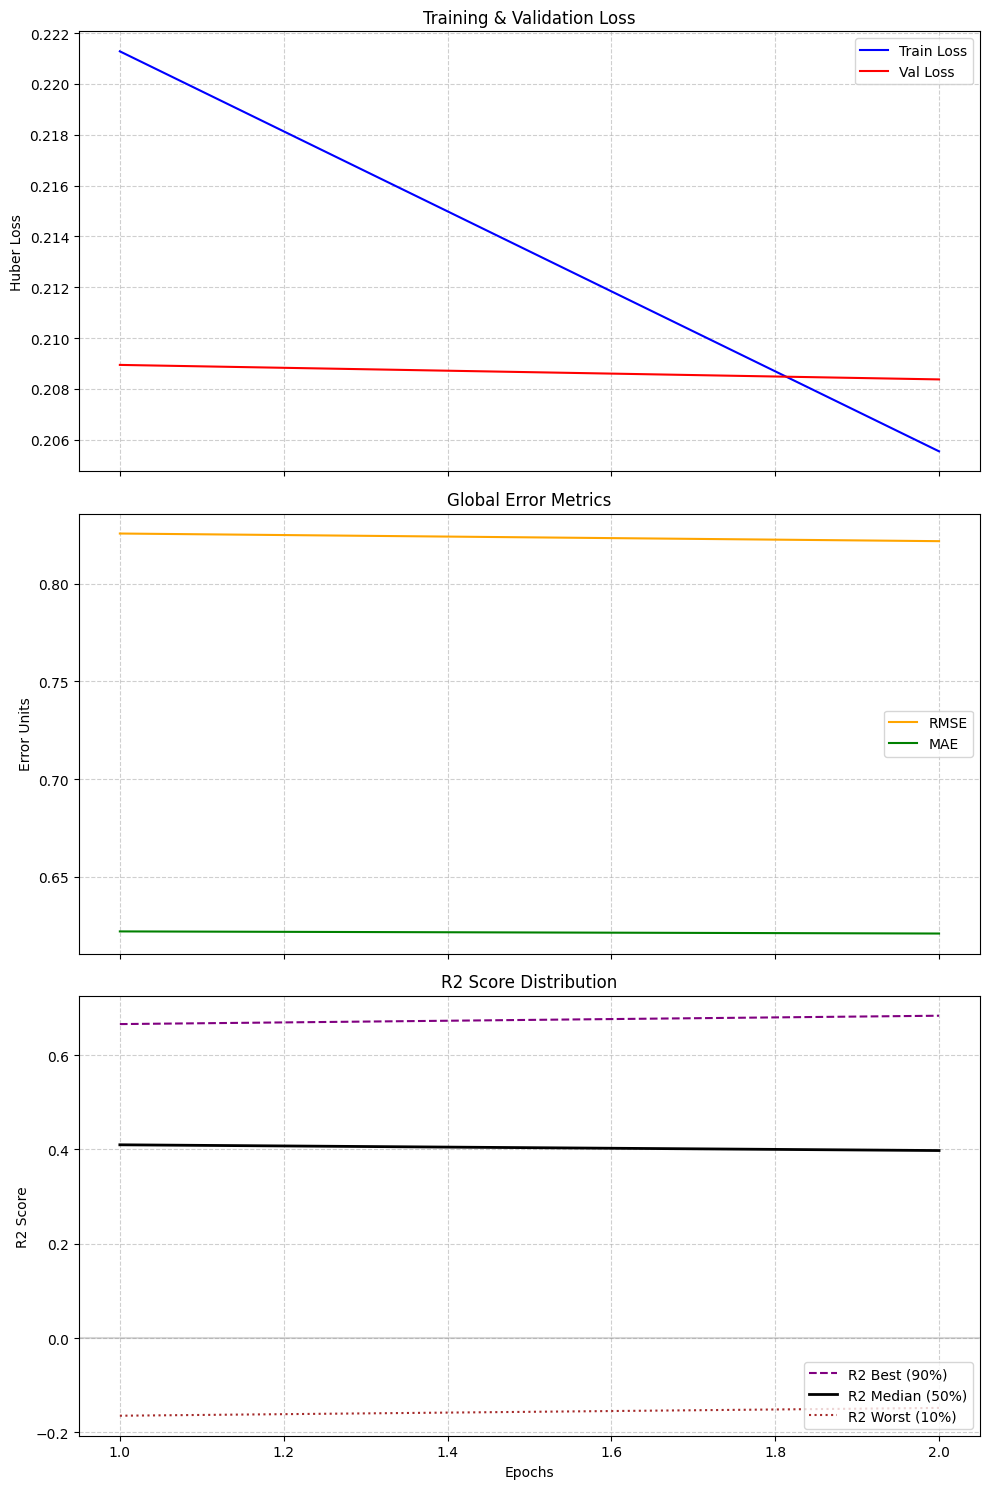

In [9]:

# 1. Model Instantiation
model = create_model(config)

# 2. Optimizer Setup
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# 3. Training
history, best_loss, last_metrics = train_model(model, train_loader, val_loader, optimizer, config)

# 4. Curves/Plots
plot_metrics(history, config.TRAINING_CURVE_PATH)

Plot

### Qualitative Analysis: 3D Stress Field Visualization

This cell performs the final visual inspection of the model's predictions. We iterate through the specific test cases identified earlier: **Best, Median, and Worst** performance.

**Key Feature: Independent Color Scaling**
The `visualize_independent_scales` function allows the color map to scale dynamically for each plot:
* **Left (Target):** Ground truth from FEM.
* **Right (Prediction):** GNN output.

**Why independent scales?**
This allows us to verify if the model has learned the correct **stress distribution patterns** (topology of the hotspots), even if the absolute **magnitudes** are underestimated (a common issue known as "over-smoothing" in regression tasks).

In [10]:


# --- 1. function for structure visualization  (AUTO-SCALE) ---
def visualize_independent_scales(target_data, pred_data, original_pos, index):
    """
    Displays Ground Truth (left) and Prediction (right) side-by-side.
    EACH GRAPH HAS ITS OWN INDIVIDUAL COLOR SCALE.
    """

    # Check for faces
    if not hasattr(target_data, 'face') or target_data.face is None:
        print("⚠️ No faces detected.")
        return

    # --- Extract Geometry ---
    x = original_pos[:, 0].cpu().numpy()
    y = original_pos[:, 1].cpu().numpy()
    z = original_pos[:, 2].cpu().numpy()

    faces = target_data.face.cpu().numpy()
    i, j, k = faces[0], faces[1], faces[2]

    # --- Extract Values ---
    val_target = target_data.y[:, 0].cpu().numpy()
    val_pred = pred_data.y[:, 0].cpu().numpy()

    # --- Calculate Individual Min/Max ---
    # For Target (Ground Truth)
    target_min, target_max = val_target.min(), val_target.max()

    # For Prediction
    pred_min, pred_max = val_pred.min(), val_pred.max()

    # --- Create Figure ---
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}]],
        subplot_titles=(
            f"GROUND TRUTH (Max: {target_max:.2f})",
            f"PREDICTION (Max: {pred_max:.2f})"
        )
    )

    # --- Trace 1: Target (Own Scale) ---
    fig.add_trace(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            intensity=val_target,
            intensitymode='vertex',
            colorscale='Jet',
            cmin=target_min, cmax=target_max, # Local scale
            opacity=1.0,
            name='Target',
            showscale=True,
            colorbar=dict(
                title="Target Stress",
                x=0.45,       # Positioned between the two graphs
                len=0.7,      # Bar length
                thickness=15
            )
        ),
        row=1, col=1
    )

    # --- Trace 2: Prediction (Own Scale) ---
    fig.add_trace(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            intensity=val_pred,
            intensitymode='vertex',
            colorscale='Jet',
            cmin=pred_min, cmax=pred_max, # Local scale
            opacity=1.0,
            name='Prediction',
            showscale=True, # Show the second bar
            colorbar=dict(
                title="Pred. Stress",
                x=1.0,        # Positioned at the far right
                len=0.7,
                thickness=15
            )
        ),
        row=1, col=2
    )

    # --- Layout ---
    fig.update_layout(
        title_text=f"Comparaison Case : Von Mises Stress Comparison - Independent Scales (Meshes {index})",
        height=600, width=1250, # Slightly wider for legends
        margin=dict(r=20, b=0, l=0, t=50),
        scene=dict(aspectmode='data'),
        scene2=dict(aspectmode='data')
    )

    fig.show()

# --- 2. EXECUTION ---
INDEX = 5502

print(f"--- Independent scales visualization for part #{INDEX} ---")

# 1. Data
target_graph = val_graphs[INDEX].clone().to(config.DEVICE)
pos_orig = target_graph.pos.clone().cpu()

# 2. Prediction
model.eval()
with torch.no_grad():
    pred_tensor = model(target_graph.x, target_graph.pos, target_graph.edge_index, batch=None)

# 3. Storage
prediction_graph = target_graph.clone()
prediction_graph.y = pred_tensor

# 4. Display
visualize_independent_scales(target_graph, prediction_graph, pos_orig, INDEX)

--- Independent scales visualization for part #5502 ---


In [11]:


# --- 1. VISUALIZATION Structures (Independent Scales) ---
def visualize_independent_scales(target_data, pred_data, original_pos, index):
    """
    Displays Ground Truth (left) and Prediction (right) side-by-side.
    EACH GRAPH HAS ITS OWN INDIVIDUAL COLOR SCALE.
    """

    # Check for faces
    if not hasattr(target_data, 'face') or target_data.face is None:
        print("⚠️ No faces detected.")
        return

    # --- Extract Geometry ---
    x = original_pos[:, 0].cpu().numpy()
    y = original_pos[:, 1].cpu().numpy()
    z = original_pos[:, 2].cpu().numpy()

    faces = target_data.face.cpu().numpy()
    i, j, k = faces[0], faces[1], faces[2]

    # --- Extract Values ---
    val_target = target_data.y[:, 0].cpu().numpy()
    val_pred = pred_data.y[:, 0].cpu().numpy()

    # --- Calculate Individual Min/Max ---
    # For Target (Ground Truth)
    target_min, target_max = val_target.min(), val_target.max()

    # For Prediction
    pred_min, pred_max = val_pred.min(), val_pred.max()

    # --- Create Figure ---
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}]],
        subplot_titles=(
            f"GROUND TRUTH (Max: {target_max:.2f})",
            f"PREDICTION (Max: {pred_max:.2f})"
        )
    )

    # --- Trace 1: Target (Own Scale) ---
    fig.add_trace(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            intensity=val_target,
            intensitymode='vertex',
            colorscale='Jet',
            cmin=target_min, cmax=target_max, # Local scale
            opacity=1.0,
            name='Target',
            showscale=True,
            colorbar=dict(
                title="Target Stress",
                x=0.45,       # Positioned between the two graphs
                len=0.7,      # Bar length
                thickness=15
            )
        ),
        row=1, col=1
    )

    # --- Trace 2: Prediction (Own Scale) ---
    fig.add_trace(
        go.Mesh3d(
            x=x, y=y, z=z, i=i, j=j, k=k,
            intensity=val_pred,
            intensitymode='vertex',
            colorscale='Jet',
            cmin=pred_min, cmax=pred_max, # Local scale
            opacity=1.0,
            name='Prediction',
            showscale=True, # Show the second bar
            colorbar=dict(
                title="Pred. Stress",
                x=1.0,
                len=0.7,
                thickness=15
            )
        ),
        row=1, col=2
    )

    # --- Layout ---
    fig.update_layout(
        title_text=f"Comparaison Case : Von Mises Stress Comparison - Independent Scales (Meshes {index})",
        height=600, width=1250,
        margin=dict(r=20, b=0, l=0, t=50),
        scene=dict(aspectmode='data'),
        scene2=dict(aspectmode='data')
    )

    fig.show()

# --- 2. EXECUTION ---
INDEX = 5502 # piece index

print(f"--- Independent scales visualization for part #{INDEX} ---")

# 1. Data
target_graph = val_graphs[INDEX].clone().to(config.DEVICE)
pos_orig = target_graph.pos.clone().cpu()

# 2. Prediction
model.eval()
with torch.no_grad():
    pred_tensor = model(target_graph.x, target_graph.pos, target_graph.edge_index, batch=None)

# 3. Storage
prediction_graph = target_graph.clone()
prediction_graph.y = pred_tensor

# 4. Display
visualize_independent_scales(target_graph, prediction_graph, pos_orig, INDEX)

--- Independent scales visualization for part #5502 ---
